# Question 6_Classification

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
import tensorflow as tf
from matplotlib import pyplot as plt
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder
import sklearn as sk
import numpy as np
from keras.models import load_model

In [3]:
# Define the path to your data
data_path = "/content/drive/MyDrive/SEMG_DB1"

## reading and preprocessing the data:
there is two function which were used to skip throgh all text files in the two folders, read their data, extract them as dataframe, delete the NaN values and delete the last column in some files that is a wrong and noist data. they also extract the labels (based on folders' name) in one hot format for each line of data.

In [4]:
def process_files(folder_path):
    data = []
    labels = []

    # Loop through each file in the folder
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.txt'):
            file_path = os.path.join(folder_path, file_name)
            # Read the text file using pandas
            df = pd.read_csv(file_path, sep='\s+', header=None, skiprows=8, engine='python')

            # Drop NaN values
            df.dropna(inplace=True)

            # Drop the last column if it exists
            if len(df.columns) > 5:  # Assuming the last column is the one you want to drop
                df = df.iloc[:, :-1]

            # Convert dataframe to numpy array
            file_data = df.values
            # Append data to the list
            data.extend(file_data)
            # Extract label from folder name
            label = os.path.basename(folder_path)
            labels.extend([label] * len(df.index))

    return data, labels

In [5]:
def load_data(data_path):
    all_data = []
    all_labels = []

    # Loop through each folder in the data path
    for folder_name in os.listdir(data_path):
        folder_path = os.path.join(data_path, folder_name)
        if os.path.isdir(folder_path):
            # Process files in the folder
            data, labels = process_files(folder_path)
            all_data.extend(data)
            all_labels.extend(labels)

    # Convert labels to categorical
    label_encoder = LabelEncoder()
    label_encoder.fit(all_labels)
    encoded_labels = label_encoder.transform(all_labels)
    categorical_labels = tf.keras.utils.to_categorical(encoded_labels)

    return np.array(all_data), categorical_labels

the functions' outputs are in the form if numpy arrays. I print their shape to see if the reading and extracting process were done completely.

In [6]:
# Load data
X, y = load_data(data_path)

# Print shapes to verify
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (1324988, 5)
y shape: (1324988, 2)


I also Print two lines of them to see their format.

In [7]:
print(X[0:2])
print(y[0:2])

[[-1.50e-03 -6.80e-03  3.00e-03 -9.10e-03 -4.50e+00]
 [-5.30e-03 -4.58e-02 -8.00e-04 -9.80e-03 -4.60e+00]]
[[1. 0.]
 [1. 0.]]


since I extracted all of the data but we don't need the 5th column for this problem, i define the x_train and y_train again. the shape of them is still correct.

In [8]:
x_train = X[: , :X.shape[1]-1]
x_train /= np.max(np.absolute(x_train))
y_train = y
x_train, y_train = sk.utils.shuffle(x_train, y_train)
print(x_train.shape, y_train.shape)

(1324988, 4) (1324988, 2)


# Training Part

In [9]:
batch_size = 2**16
num_classes = 2

## With ReLU

In [10]:
epochs = 200
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(4,)))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='relu'))

model.summary()

model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split = 0.2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               640       
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 2)                 130       
                                                                 
Total params: 9026 (35.26 KB)
Trainable params: 9026 (35.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
17/17 [==============================] - 5s 249ms/step - loss: 3.1760 - accuracy: 0.5452 - val_loss: 2.4821 - val_accuracy: 0.6126
Epoch 2/200

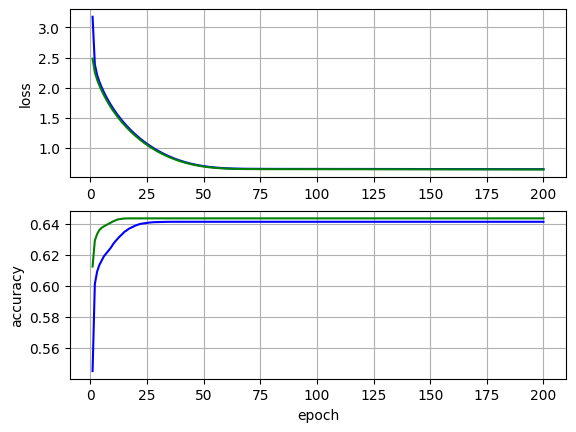

In [11]:
plt.figure()
plt.subplot(2,1,1);
plt.plot(range(1,epochs+1), history.history['loss'], 'b',
         range(1,epochs+1), history.history['val_loss'],'g')
plt.ylabel('loss'); plt.grid()
plt.subplot(2,1,2);
plt.plot(range(1,epochs+1), history.history['accuracy'], 'b',
         range(1,epochs+1), history.history['val_accuracy'],'g')
plt.ylabel('accuracy'); plt.grid(); plt.xlabel('epoch')
plt.show()

In [12]:
model.save('model_HW1_6_relu_1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## With PReLU

In [13]:
epochs = 200
model = Sequential()
model.add(Dense(128, activation=keras.layers.LeakyReLU(alpha=0.5), input_shape=(4,)))
model.add(Dropout(0.2))
model.add(Dense(64, activation=keras.layers.LeakyReLU(alpha=0.5)))
model.add(Dense(num_classes, activation=keras.layers.LeakyReLU(alpha=0.5)))

model.summary()

model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split = 0.2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               640       
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 2)                 130       
                                                                 
Total params: 9026 (35.26 KB)
Trainable params: 9026 (35.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
17/17 [==============================] - 5s 233ms/step - loss: 3.0928 - accuracy: 0.5870 - val_loss: 2.3143 - val_accuracy: 0.6114
Epoch 2/2

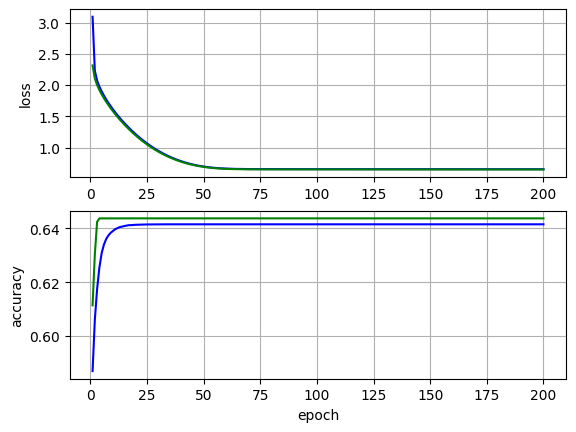

In [14]:
plt.figure()
plt.subplot(2,1,1);
plt.plot(range(1,epochs+1), history.history['loss'], 'b',
         range(1,epochs+1), history.history['val_loss'],'g')
plt.ylabel('loss'); plt.grid()
plt.subplot(2,1,2);
plt.plot(range(1,epochs+1), history.history['accuracy'], 'b',
         range(1,epochs+1), history.history['val_accuracy'],'g')
plt.ylabel('accuracy'); plt.grid(); plt.xlabel('epoch')
plt.show()

In [16]:
model.save('model_HW1_6_Prelu_1.h5')

## With eLu

In [17]:
epochs = 200
model = Sequential()
model.add(Dense(128, activation='elu', input_shape=(4,)))
model.add(Dropout(0.2))
model.add(Dense(64, activation='elu'))
model.add(Dense(num_classes, activation='elu'))

model.summary()

model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split = 0.2)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 128)               640       
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 2)                 130       
                                                                 
Total params: 9026 (35.26 KB)
Trainable params: 9026 (35.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
17/17 [==============================] - 5s 259ms/step - loss: 2.7851 - accuracy: 0.5426 - val_loss: 2.0568 - val_accuracy: 0.5580
Epoch 2/2

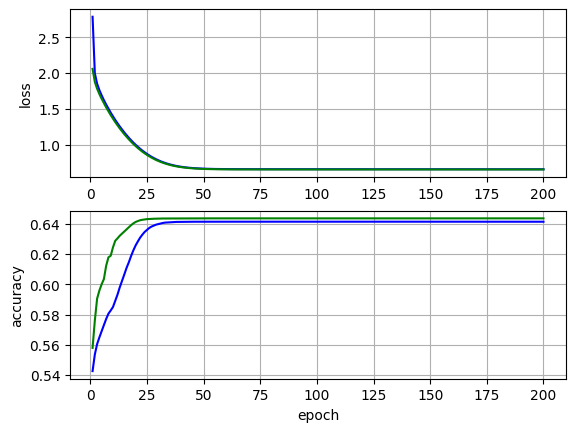

In [18]:
plt.figure()
plt.subplot(2,1,1);
plt.plot(range(1,epochs+1), history.history['loss'], 'b',
         range(1,epochs+1), history.history['val_loss'],'g')
plt.ylabel('loss'); plt.grid()
plt.subplot(2,1,2);
plt.plot(range(1,epochs+1), history.history['accuracy'], 'b',
         range(1,epochs+1), history.history['val_accuracy'],'g')
plt.ylabel('accuracy'); plt.grid(); plt.xlabel('epoch')
plt.show()

In [19]:
model.save('model_HW1_6_elu_1.h5')

# Loading Part
loading the saved models to see their result:
it seems that these MLPs can't rich more than 64% in the test data, but they can be different in training data according to their activation function. I mean maybe MLPs are not good enough to show the differences in results in different activation function.

In [22]:
# loading the best model
model = load_model('model_HW1_6_relu_1.h5')
# viewing the summary
model.summary()
# printing the loss and accuracy of the model on trainig data
score = model.evaluate(x_train, y_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               640       
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 2)                 130       
                                                                 
Total params: 9026 (35.26 KB)
Trainable params: 9026 (35.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Train loss: 0.6472278237342834
Train accuracy: 0.6418858170509338


In [27]:
# loading the best model
model = load_model('model_HW1_6_Prelu_1.h5')
# viewing the summary
model.summary()
# printing the loss and accuracy of the model on trainig data
score = model.evaluate(x_train, y_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               640       
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 2)                 130       
                                                                 
Total params: 9026 (35.26 KB)
Trainable params: 9026 (35.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Train loss: 0.6512812376022339
Train accuracy: 0.6418858170509338


In [28]:
# loading the best model
model = load_model('model_HW1_6_elu_1.h5')
# viewing the summary
model.summary()
# printing the loss and accuracy of the model on trainig data
score = model.evaluate(x_train, y_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 128)               640       
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 2)                 130       
                                                                 
Total params: 9026 (35.26 KB)
Trainable params: 9026 (35.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Train loss: 0.6522737145423889
Train accuracy: 0.6418858170509338
